# Dog or Coyote?

# Purpose

The purpose of this notebook is to take random images of dogs and coyotes and train the computer to be able to tell the difference.

We will be exposed to deep learning concepts. Python libraries that are new to us are tensorflow and keras for executing these models.

# Preparing the data sets

In [1]:
#import libraries

import numpy as np
import pandas as pd
import os
import random 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization



Using TensorFlow backend.


In [2]:
#importing data from files and giving them variables

train_data = "./train"
test_data = "./test"

IMAGE_WIDTH=150
IMAGE_HEIGHT=150

In [3]:

#Create dataframe of train data set
#This dataframe will be a mix of dog and coyote images, with each being labeled 
#into a category based on the filename.
filenames = os.listdir(train_data)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

dog_coy_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Data Exploration

## Print first and last rows of data

First we will look at a piece of the training data to see make sure we know what our data looks like. Our dataframe has one column with the filename, and one column that labels the image as a 1(dog) or a 0(coyote). 

In [4]:
#print first of dataframe

dog_coy_df.head()

,filename,category
0,dog.8011.jpg,1
1,dog.7322.jpg,1
2,image1535 copy 34.png,0
3,dog.1753.jpg,1
4,dog.5535.jpg,1


In [5]:
#print last 5 rows of dataframe

dog_coy_df.tail()

,filename,category
24604,dog.8008.jpg,1
24605,dog.1992.jpg,1
24606,dog.12412.jpg,1
24607,image1217.png,0
24608,image1524 copy 44.png,0


## Visualize the number of dog images vs coyotes

Originally, we had a very small number of coyote images. For the sake of having a similar number of dog and coyote images, and for our training model to work properly, we copied the coyote images repeatedly. This is definitly not ideal but in this case we will just work with it. As you can see, the number of coyote images is now almost equal to the dogs. This is a nice graph to see to better understand our data, especially as we were trying to make the numbers even. 

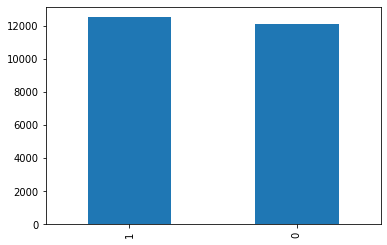

In [6]:

#Print plot with category values, Dogs: 1 Coyotes: 0

dog_coy_df['category'].value_counts().plot.bar()


## Show random sample of data

Showing a random sample of the data is helpful because it can tell us more about our data besides the fact there are dogs and coyotes in them. Sometimes the data has characteristics we woud not normally think about. For example, some images have humans in them, multiple dogs or coyotes, or fences and gates. It is good to keep these things in mind when creating a model for our data. 

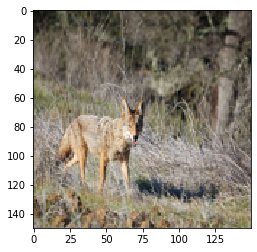

In [7]:
#showing random sample of images

sample = random.choice(filenames)
image = load_img("./train/"+sample)
new_image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(new_image)
        
                         

# Train Model

This is where we process images and do a bunch of training stuff that I dont understand yet.

In [8]:
# initializing the model
model = Sequential()

#adding layers via the .add() method

#The activation parameter to the Conv2D class is simply a 
#convenience parameter which allows you to supply a string, 
#which specifies the name of the activation function you want to apply after performing the convolution.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))

#Batch normalization is used to stabilize and perhaps accelerate the learning process. 
model.add(BatchNormalization())

#A pooling layer is a new layer added after the convolutional layer. 
#Specifically, after a nonlinearity (e.g. ReLU) has been applied to the feature maps output 
#by a convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2)))

#Dropout is a technique used to prevent a model from overfitting.
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#A flatten operation on a tensor reshapes the tensor to have the shape that is equal to 
#the number of elements contained in tensor non including the batch dimension.
model.add(Flatten())

#A dense layer is just a regular layer of neurons in a neural network.
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)       

# Overfitting Refinement

Overfitting is something we want to avoid. It occurs when our model does a better job predicting
our test data. This seems counterintuitive, but if it is doing to well, means that something is off 
and we are not training our computer to do what we think we are training it to do. The example of the computer trained to see snow instead of wolves is a good example. 

In [9]:
#When our machine stops improving in its training performance, we can stop training. 
#So, we can set the patience to number of epochs that do not see improvement before we stop. 
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]


In [10]:
dog_coy_df['category'] = dog_coy_df['category'].replace({0: 'coyote', 1: 'dog'})

# Validation

In [11]:
#We want our train data to be split in a 20-80 so that the validation is 20%.
train_df, validate_df = train_test_split(dog_coy_df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

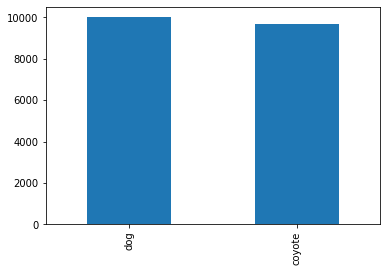

In [12]:
train_df['category'].value_counts().plot.bar()

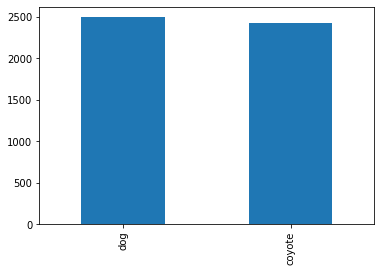

In [13]:

validate_df['category'].value_counts().plot.bar()

In [14]:
#
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Training Generator

In [15]:
FAST_RUN = False
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 19686 validated image filenames belonging to 2 classes.


/Applications/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 4922 validated image filenames belonging to 2 classes.


## See how our generator works¶

In [17]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


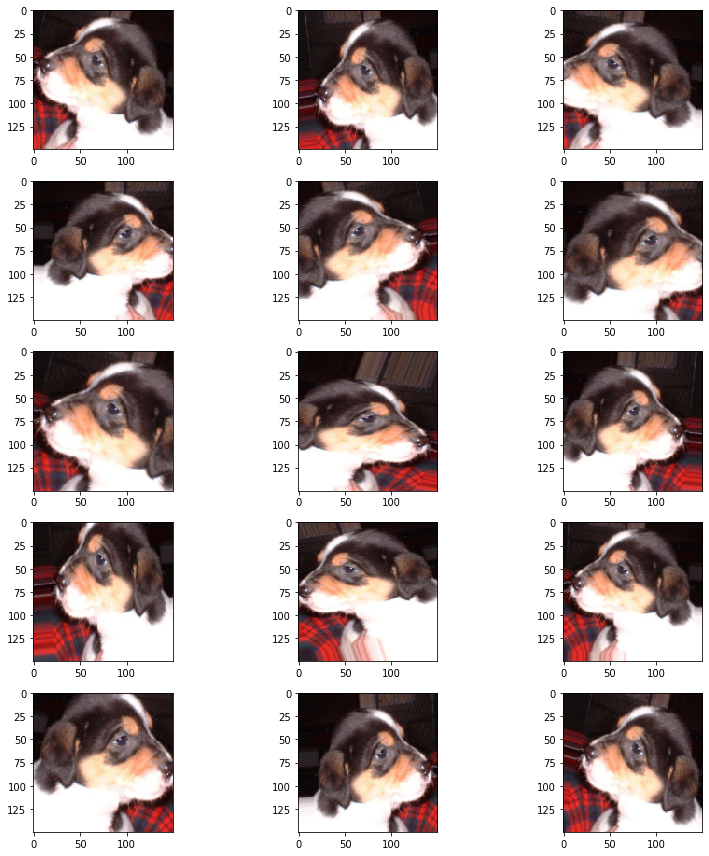

In [18]:
#This is a good example of how an image can be processed in different ways.
#Generating an image in these different ways is good for us to see, because we can think
#about how differently the computer sees an image compared to the human eye.
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

This is where we fit the model and test its accuracy. The graph it is supposed to generate will 
be a visualization of its accuracy. Based on the results, our accuracy repeatedly stays in the 0.80 - 0.90 range. We do get an error that we thought would be solved by increasing the number of images, which we did. However, now we think maybe we needed to split our train data better. 

Choosing the number of epochs is important as well. We do not want to do too many at risk of overfitting the data. But we also do not want to do too few, risking a poorer model. While we did do some Fast Runs of only 3 epochs while working on our code, for our final version we will run a full 10, though this is still not very many. We chose to do this for the sake of run time. 

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
epochs=3 if FAST_RUN else 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1312/1312 [==============================] - 2198s 2s/step - loss: 0.4298 - accuracy: 0.8334 - val_loss: 1.7598 - val_accuracy: 0.6433
Epoch 2/10


/Applications/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1312/1312 [==============================] - 3085s 2s/step - loss: 0.2629 - accuracy: 0.8981 - val_loss: 0.1236 - val_accuracy: 0.8873
Epoch 3/10
1312/1312 [==============================] - 5432s 4s/step - loss: 0.2320 - accuracy: 0.9123 - val_loss: 0.8583 - val_accuracy: 0.7899
Epoch 4/10
1312/1312 [==============================] - 2100s 2s/step - loss: 0.1932 - accuracy: 0.9291 - val_loss: 1.2633 - val_accuracy: 0.6199
Epoch 5/10
1312/1312 [==============================] - 2147s 2s/step - loss: 0.1808 - accuracy: 0.9360 - val_loss: 0.2432 - val_accuracy: 0.8714
Epoch 6/10
1312/1312 [==============================] - 2493s 2s/step - loss: 0.1675 - accuracy: 0.9399 - val_loss: 7.7318e-04 - val_accuracy: 0.9460
Epoch 7/10
1312/1312 [==============================] - 2211s 2s/step - loss: 0.1536 - accuracy: 0.9470 - val_loss: 0.5554 - val_accuracy: 0.9684
Epoch 8/10
1312/1312 [==============================] - 2185s 2s/step - loss: 0.1581 - accuracy: 0.9461 - val_loss: 0.4880 - val_ac